In [421]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import pi
from scipy.interpolate import interp1d
import matplotlib.animation as animation


colors = ['#003D5B', '#D1495B', '#EDAE49', '#00798C', '#401F3E'] 

# Simulateur 1. Diffusion sur un plan xy

Pour simuler un mouvement brownien en 2D, on cumule un mouvement brownien en x et un mouvement brownien en y.

source: https://ipython-books.github.io/133-simulating-a-brownian-motion/ 

In [422]:
class DiffusionSimulator():

    def __init__(self, t:int, dt:int, dx:int, D:float):
        """Class that simulate de diffusion of a set of particule.

        Args:
            t (int): Total time of the simulation in seconds.
            dt (int): Time increment in second.
            dx (int): Localisation precision in meters.
            D (float): Diffusion coefficient.
        """
        self.TotalTime = t
        self.TimeSteps = dt
        self.LocalizationPrecision = dx
        self.DiffusionCoefficient = D


    def generation_motion_rectangle(self, x_limit:float=1e-6,
                                    y_limit:float=1e-6):

        x_space = np.linspace(0, 1e-6, 1000)
        n = int(self.TotalTime/self.TimeSteps)

        concentration = 1/np.sqrt(4*pi*self.DiffusionCoefficient*self.TimeSteps)*np.exp(-x_space**2/(4*self.DiffusionCoefficient*self.TimeSteps))

        concentration/=np.sum(concentration)

        x, y = np.zeros(n), np.zeros(n)
        old_x, old_y = 0, 0

        for i in range(n):
            angle = np.random.uniform(0,2*pi)
            r = np.random.choice(a=x_space, p=concentration, size=1)[0]
            new_x = old_x + r*np.cos(angle)
            new_y = old_y + r*np.sin(angle)

            if new_x > x_limit/2:
                # plt.plot([old_x, new_x], [old_y, new_y])
                # plt.axvline(x_limit/2)
                # plt.show()
                temp_y = interp1d([old_x, new_x], [old_y, new_y])(x_limit/2)
                temp_x = x_limit/2
                initial_to_wall = np.sqrt((temp_y - old_y)**2 + (temp_x - old_x)**2)
                
                final_dist_remaining = r - initial_to_wall
                new_angle = np.pi - angle

                new_x = temp_x + final_dist_remaining*np.cos(new_angle)
                new_y = temp_y + final_dist_remaining*np.sin(new_angle)

            if new_x < -x_limit/2:

                temp_y = interp1d([old_x, new_x], [old_y, new_y])(-x_limit/2)
                temp_x = -x_limit/2
                initial_to_wall = np.sqrt((temp_y - old_y)**2 + (temp_x - old_x)**2)
                
                final_dist_remaining = r - initial_to_wall
                new_angle = (np.pi) - angle

                new_x = temp_x + final_dist_remaining*np.cos(new_angle)
                new_y = temp_y + final_dist_remaining*np.sin(new_angle)

            x[i], old_x = new_x, new_x
            y[i], old_y = new_y, new_y
        self.data = (x,y)


    def box_limit(self, x_2_test:float, y_2_test:float,
                  x:float=1, y:float=1e-6)->bool:
        """Method that create a box limiting the propagation of the particule. Check if the particule is out of bound. If out of bound, return False so it will create a new iteration to force the particule in the restricted zone.

        All the units in this method must be in meters.

        Args:
            x_2_test (float): New x position to test.
            y_2_test (float): New y position to test.
            x (float, optional): Full width of the rectangle. Defaults to 1.
            y (float, optional): Full height of the rectangle. Defaults to 1e-6.

        Returns:
            bool: Indicate if the position is in bound. If False, retry the movement.
        """
        if x_2_test <= -1*x/2 or x_2_test >= x/2:
            return False
        if y_2_test <= -1*y/2 or y_2_test >= y/2:
            return False
        else:
            return True


    def circle_limit(self, x_2_test:float, y_2_test:float,
                     radius:float=2e-6)->bool:
        """Method that create a circle limiting the propagation of the particule. Check if the particle is in bound. If out of bound, return False so it will indicate the need of a new iteration to force the particule in the restricted zone.

        All the units in this method must be in meters.

        Args:
            x_2_test (float): New x position to test.
            y_2_test (float): New y position to test.
            radius (float, optional): Radius of the circle. Defaults to 2e-6.

        Returns:
            bool: Indicate if the position is in bound. If False, retry the movement.
        """
        if x_2_test**2 + y_2_test**2 >= radius**2:
            return False
        else:
            return True

    def GenerateMotion(self, limitation:str="rectangle",
                       limitation_constraints:list=[10,10]):
        """Method that generate the motion of the particule with the limitation of the particule range. By default, the particule is in a box of 10X10 meters.

        Args:
            limitation (str, optional): rectangle or circle. Defaults to "rectangle".
            limitation_constraints (list, optional): [x, y] or [radius]. All in meters. Defaults to (10,10).
        """

        def sim_motion(limitation:str, limitation_constraint:list):
            """Function that simulate the motion with respect to the constraint.

            Args:
                limitation (str): rectangle or circle
                limitation_constraint (list): [x, y] or [radius]
            """
            x_space = np.logspace(-9,-2,1000)
            n = int(self.TotalTime/self.TimeSteps)

            concentration = 1/np.sqrt(4*pi*self.DiffusionCoefficient*self.TimeSteps)*np.exp(-x_space**2/(4*self.DiffusionCoefficient*self.TimeSteps))
            concentration/=np.sum(concentration)

            def calculate_new_position():
                """Small function that calculate the new position of the particule"""
                angle = np.random.uniform(0,2*pi)
                r = np.random.choice(a=x_space,p=concentration, size=1)[0]
                new_x = old_x + r*np.cos(angle)
                new_y = old_y + r*np.sin(angle)
                return new_x, new_y

            x, y = np.zeros(n), np.zeros(n)
            old_x, old_y = 0, 0

            for i in range(n):
                new_x, new_y = calculate_new_position()

                while limitation(new_x, new_y, *limitation_constraint) == False:

                    


                    new_x, new_y = calculate_new_position()

                x[i], old_x = new_x, new_x
                y[i], old_y = new_y, new_y
            self.data = (x,y)



        if limitation == "rectangle":
            limitation = self.box_limit
            sim_motion(limitation, limitation_constraints)

        if limitation == "circle":
            limitation = self.circle_limit
            sim_motion(limitation, limitation_constraints)


    def MeanSquareDisplacement(self):
        """Method that calculate the mean square displacement.

        Returns:
            np.array: Array containing the MSD
        """
        X,Y= self.data
        MSD = []
        for i in range(2,X.shape[0]):
            x = X[:i]
            y = Y[:i]
            r = np.sqrt(x**2 + y**2)
            msd = np.diff(r)**2
            MSD.append(np.mean(msd))
        return np.cumsum(np.array(MSD))


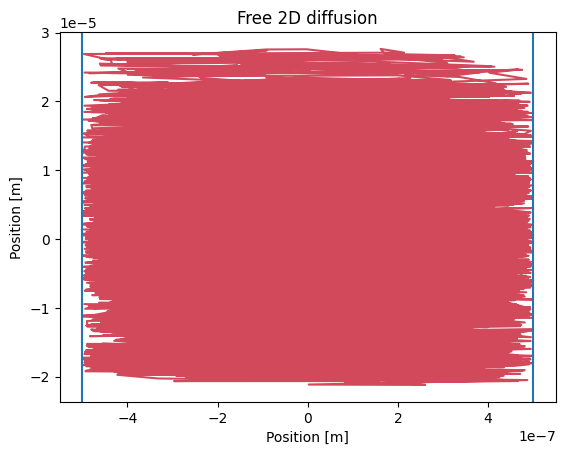

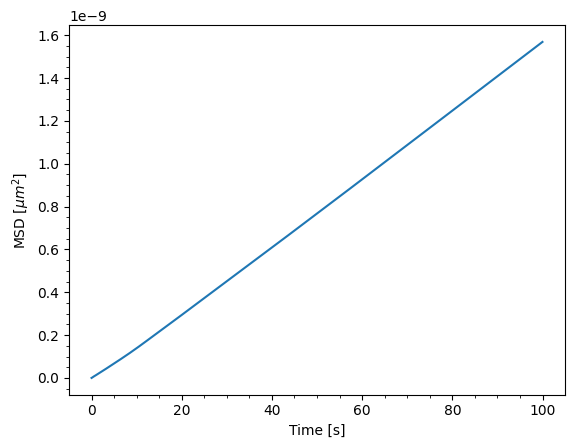

In [423]:
Simulation = DiffusionSimulator(t=100, dt=0.01, dx=1, D=1e-9)
# Simulation.GenerateMotion()   # Uncomment for og
Simulation.generation_motion_rectangle(1e-6, 1e-6) # uncomment this for limits
x,y = Simulation.data
plt.plot(x,y,color = colors[1])
plt.title("Free 2D diffusion")
plt.xlabel("Position [m]")
plt.ylabel("Position [m]")
plt.axvline(1e-6/2)
plt.axvline(-1e-6/2)
plt.gca().ticklabel_format(style='sci', scilimits=(0, 0))
plt.show()

time_array = np.linspace(0,Simulation.TotalTime,
                         int(Simulation.TotalTime/Simulation.TimeSteps))
MSD = Simulation.MeanSquareDisplacement()

# def droite(x, a, b):
#     return a*x*4 + b
# popt, pcov = curve_fit(droite, time_array, MSD)

plt.plot(time_array[0:len(MSD)], MSD)
# plt.plot(time_array, droite(time_array, *popt))
plt.xlabel("Time [s]")
plt.ylabel(r"MSD [$\mu m^2$]")
plt.minorticks_on()
plt.show()

# print(f"Le coefficient de diffusion est de ({popt[0]} ± {np.diag(pcov)[0]}).")


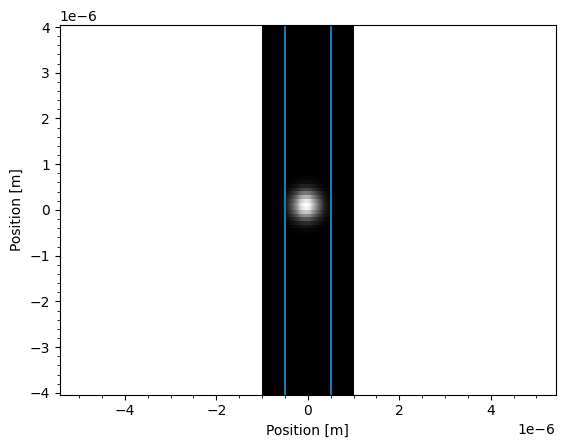

In [435]:
# Code for gaussian animation
limit = 1e-6
size = 100

x,y = Simulation.data

x_grid, y_grid = np.meshgrid(
    np.linspace(-limit, limit, size),
    np.linspace(-4*limit, 4*limit, size))


def gaussian(x0, y0, x_grid, y_grid, sigma):
    return (1/(2*np.pi*sigma**2) * np.exp(-((x_grid-x0)**2/(2*sigma**2)
     + (y_grid-y0)**2/(2*sigma**2))))


fig, ax = plt.subplots()
ax.pcolormesh(x_grid, y_grid, gaussian(x[0], y[0], 
                                       x_grid, y_grid, 208e-9), cmap="gray")
ax.minorticks_on()
ax.axvline(limit/2)
ax.axvline(limit/-2)
ax.axis("equal")
ax.set(ylabel=r"Position [m]",
       xlabel=r"Position [m]")#,
    #    ylim=[-5*limit, 5*limit],
    #    xlim=[-1.5* limit, 1.5*limit])
plt.show()

def update(frame):
    data = gaussian(x[frame], y[frame], x_grid, y_grid, 208e-9)
    background_noise = np.random.normal(1, 5000, data.shape)
    poisson_noise = np.random.poisson(10000, data.shape)
    ax.pcolormesh(x_grid, y_grid, (data + poisson_noise + background_noise), cmap="gray")


ani = animation.FuncAnimation(fig=fig, func=update, interval=10)
ani.save("test.gif", writer="pillow")
# plt.show()


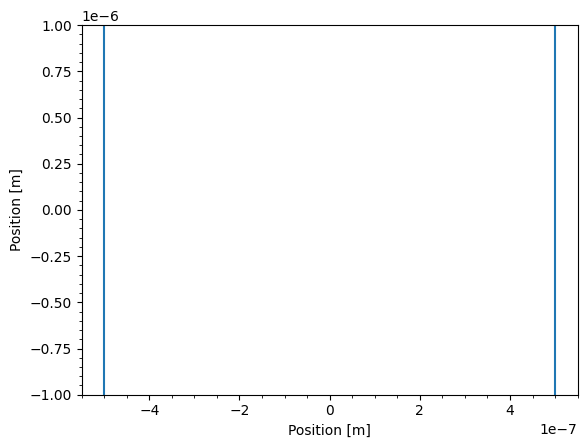

In [425]:
# Code for single point animation

x,y = Simulation.data

fig, ax = plt.subplots()

position = ax.scatter(x[0], y[0])
ax.minorticks_on()
ax.axvline(1e-6/2)
ax.axvline(-1e-6/2)
ax.set(ylabel=r"Position [m]",
       xlabel=r"Position [m]",
       ylim=[-1e-6, 1e-6])

def update(frame):
    data = np.stack([x[frame], y[frame]]).T
    position.set_offsets([x[frame], y[frame]])

    return position
ani = animation.FuncAnimation(fig=fig, func=update, interval=10)
ani.save("test.gif", writer="pillow")
plt.show()



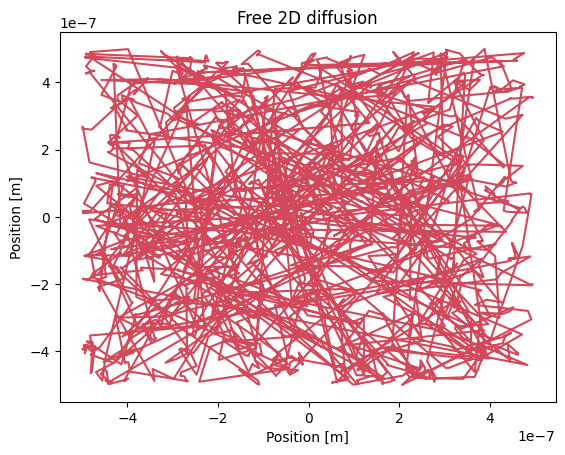

In [426]:
Simulation = DiffusionSimulator(t=20, dt=0.01, dx=1, D=1e-9)
# Simulation.GenerateMotion()   # Uncomment for og
Simulation.GenerateMotion(limitation="rectangle",
                          limitation_constraints=[1e-6, 1e-6]) # uncomment this for limits
x,y = Simulation.data
plt.plot(x,y,color = colors[1])
plt.title("Free 2D diffusion")
plt.xlabel("Position [m]")
plt.ylabel("Position [m]")
# plt.axhline(0.5e-6)
# plt.axhline(-0.5e-6)
plt.gca().ticklabel_format(style='sci', scilimits=(0, 0))
plt.show()

In [427]:

time_array = np.linspace(0,Simulation.TotalTime,
                         int(Simulation.TotalTime/Simulation.TimeSteps))
MSD = Simulation.MeanSquareDisplacement()

def droite(x, a, b):
    return a*x*4 + b
popt, pcov = curve_fit(droite, time_array, MSD)

plt.plot(time_array, MSD)
plt.plot(time_array, droite(time_array, *popt))
plt.xlabel("Time [s]")
plt.ylabel(r"MSD [$\mu m^2$]")
plt.minorticks_on()
plt.show()

print(f"Le coefficient de diffusion est de ({popt[0]} ± {np.diag(pcov)[0]}).")

ValueError: operands could not be broadcast together with shapes (2000,) (1998,) 

## Impact du temps de simulation sur $D$
Afin de déterminer l'impact du temps de simulation sur la mesure estimée du coefficient de diffusion, le ```curve_fit``` sera effectué à chaque seconde afin de voir la convergence de la mesure.

In [ ]:
time_array = np.linspace(0,Simulation.TotalTime,
                         int(Simulation.TotalTime/Simulation.TimeSteps))

MSD = Simulation.MeanSquareDisplacement()


msd_values = np.zeros(Simulation.TotalTime - 1)
def droite(x, a, b):
    return a*x *4 + b


for i in enumerate(range(int(1/Simulation.TimeSteps),
               int(Simulation.TotalTime/Simulation.TimeSteps),
               int(1/Simulation.TimeSteps))):
    popt, pcov = curve_fit(droite, time_array[0:i[1]], MSD[0:i[1]])
    msd_values[i[0]] = popt[0]

plt.plot(msd_values)
plt.minorticks_on()
plt.show()